$\textbf{*** This version uses the }\texttt{Dataloader, Asset, Portfolio}\textbf{ classes to load data}$

In [1]:
import sys
import importlib
sys.path.append('../')

from IPython.display import display, Math, Latex

# From data_preparation classes
from src.finance_ml.data_preparation.data_preparation import DataLoader

from src.finance_ml.denoising.denoising import Denoising
from src.finance_ml.indicators.indicators import Indicators
from src.finance_ml.volatility.volatility import Volatility

In [2]:
# Import required packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import math

## Reading the Data File

In [3]:
# Defining time_index_col (must be the same column in all inputs) and keep_cols refering to the columns that will remain in the dataset
dataloader = DataLoader(time_index_col= 'DATE', 
                    keep_cols = ['VOLUME','OPEN', 'HIGHT', 'LOW', 'CLOSE', 'VW','TRANSACTIONS'])

Here we will select $N=15,000$ ticks from our database for simplicity. We also select the equity $\textbf{AAPL}-Apple$ from  the data available.

In [4]:
# Example Files
fname_RUBEUR = 'FX/RUBEUR_2020-04-07_2022-04-06.parquet'
fname_USDBRL = 'FX/USDBRL_2020-04-07_2022-04-06.parquet'
fname_AAPL = 'equities/AAPL_2020-04-07_2022-04-06.parquet'

# No. of Records from example dataset
N = 15000

In [5]:
# Dataset chosen in this simulation
ticker = 'AAPL'
fname = fname_AAPL

In [6]:
# loading assets into to an unique df
df = dataloader.load_dataset({ticker:'../data/'+fname}).iloc[:N]
display(df)

,AAPL_VOLUME,AAPL_OPEN,AAPL_HIGHT,AAPL_LOW,AAPL_CLOSE,AAPL_VW,AAPL_TRANSACTIONS
DATE,,,,,,,
2020-04-07 12:17:00,14256.0,67.3500,67.3625,67.3275,67.3375,67.3454,45
2020-04-07 12:18:00,16552.0,67.3501,67.3625,67.3250,67.3250,67.3407,57
2020-04-07 12:19:00,80172.0,67.3250,67.4475,67.3250,67.4225,67.3937,149
2020-04-07 12:20:00,183740.0,67.4475,67.4700,67.3125,67.3700,67.3671,159
2020-04-07 12:21:00,35372.0,67.3500,67.3850,67.2975,67.2975,67.3469,102
...,...,...,...,...,...,...,...
2020-05-06 10:37:00,3600.0,74.9575,74.9625,74.9575,74.9625,74.9582,16
2020-05-06 10:38:00,1144.0,74.9550,74.9550,74.9550,74.9550,74.9471,6
2020-05-06 10:43:00,3652.0,74.9425,74.9500,74.9425,74.9500,74.9466,15


The work columns are divided in $04$ groups:

> $\texttt{data_cols}$ - Contains the primary data from the dataframe

> $\texttt{var_cols}$ - Indicators calculated with class $\texttt{Indicators}$

> $\texttt{normvar_cols}$ - Normalized indicators calculated with class $\texttt{Indicators}$

> $\texttt{vol_cols}$ - Volatility indexes calculated with class $\texttt{Volatility}$

In [7]:
data_cols = ['DATE', 'OPEN', 'HIGHT', 'LOW', 'CLOSE', 'VW', 'VOLUME']

# Columns of indicators with default parameters
var_cols = ['CLOSE_returns',
       'CLOSE_log_returns', 'CLOSE_price_change',
       'CLOSE_pct_change', 'RA_5', 'RA_10', 'AMPL',
       'OPNCLS', 'MA_5', 'MA_10', 'V_MA_5', 'V_MA_10',
       'V_MA_20', 'KAMA_w10p(02,30)', 'PPO_w(26,12)',
       'PVO_w(26,12)s09', 'PVOH_w(26,12)s09',
       'PVOsgn_w(26,12)s09', 'ROC_w12', 'RSI_w14',
       'StRSI_w14s(03,03)', 'StRSId_w14s(03,03)',
       'StRSIk_w14s(03,03)', 'SO_w14s03', 'SOsgn_w14s03',
       'AOI_w(05,34)', 'TSI_w(25,13)',
       'UO_wi(07,14,28)wg(4.0,2.0,1.0)', 'WRI_14', 'ADI',
       'CMF_w20', 'EOM_w14', 'EMV_w14', 'FI_w13',
       'MFI_w14', 'NVI', 'OBV', 'VPT', 'VWAP_w14',
       'ADXP_w14', 'ADXN_w14', 'AROOND_w25', 'AROON_w25',
       'AROONU_w25', 'CCI_w20', 'DPO_w20', 'EMA_w14', 'SMA_w14',
       'ICHIA_w(09,26,52)', 'ICHIB_w(09,26,52)',
       'ICHIBL_w(09,26,52)', 'ICHICL_w(09,26,52)',
       'KST_r(10,15,20,30)_w(10,10,10,15)',
       'KSTD_r(10,15,20,30)_w(10,10,10,15)',
       'KSTS_r(10,15,20,30)_w(10,10,10,15)', 'MACD_w(26,12,09)',
       'MACDD_w(26,12,09)', 'MACDS_w(26,12,09)', 'MI_w(09,25)',
       'PSAR_s(0.02,0.2)', 'PSARD_s(0.02,0.2)',
       'PSARDI_s(0.02,0.2)', 'PSARU_s(0.02,0.2)',
       'PSARUI_s(0.02,0.2)', 'STC_w(50,23)c10s(03,03)',
       'TRIX_w15', 'VI_w14', 'VIN_w14', 'VIP_w14',
       'WMA_w09']

# Columns of volatility indicators with default parameters
vol_cols = ['BBM_w20', 'BBH_w20', 'BBL_w20',
       'BBHI_w20', 'BBLI_w20', 'BBW_w20', 'BBP_w20',
       'ATR_w14', 'DCM_w20', 'DCH_w20', 'DCL_w20',
       'DCW_w20', 'KCH_w20wa10m02', 'KCHI_w20wa10m02',
       'KCL_w20wa10m02', 'KCLI_w20wa10m02', 'KCM_w20wa10m02',
       'KCW_w20wa10m02', 'UI_w14', 'CorwinSchultz_sl01',
       'HodgesTompkins_w30tp252', 'YangZhang_w30tp252',
       'RogersSatchell_w30tp252', 'GarmanKlass_w30tp252']

# For each of calculated column, we add the ticker code, as standardized by class 𝙳𝚊𝚝𝚊𝙻𝚘𝚊𝚍𝚎𝚛
var_cols = [ticker+'_'+col for col in var_cols]
vol_cols = [ticker+'_'+col for col in vol_cols]
norm_cols = [col + '_norm' for col in vol_cols+var_cols]

# Data Augmentation

In order to increase the number of variables considered in the covariance matrix, this module introduced some sample $\textit{indicators}$ and $\textit{volatility}$ indexes calculated over the asset's data.

After $\textbf{Volatility}$ and $\textbf{Data Generation}$ groups introduced the appropriate classes, we can eliminate this portion of code and dependencies.

## Calculate Volatility Indicators

In [8]:
# Select Volatility transformer
vol_processor = Volatility(ticker = ticker)

# Calculate Volatility over input dataframe
df = vol_processor.fit_transform(df)

In [9]:
# Display Dataframe with Volatility indicators
display(df[vol_cols].dropna(axis=0))

,AAPL_BBM_w20,AAPL_BBH_w20,AAPL_BBL_w20,AAPL_BBHI_w20,AAPL_BBLI_w20,AAPL_BBW_w20,AAPL_BBP_w20,AAPL_ATR_w14,AAPL_DCM_w20,AAPL_DCH_w20,...,AAPL_KCL_w20wa10m02,AAPL_KCLI_w20wa10m02,AAPL_KCM_w20wa10m02,AAPL_KCW_w20wa10m02,AAPL_UI_w14,AAPL_CorwinSchultz_sl01,AAPL_HodgesTompkins_w30tp252,AAPL_YangZhang_w30tp252,AAPL_RogersSatchell_w30tp252,AAPL_GarmanKlass_w30tp252
DATE,,,,,,,,,,,,,,,,,,,,,
2020-04-07 12:47:00,67.456505,67.610106,67.302904,0.0,0.0,0.455407,0.731103,0.052798,67.41375,67.5750,...,67.408238,0.0,67.454543,0.137292,0.048312,8.941773e-05,0.010017,0.010768,0.138846,0.008604
2020-04-07 12:48:00,67.466505,67.613722,67.319288,0.0,0.0,0.436414,0.741124,0.051169,67.41375,67.5750,...,67.419322,0.0,67.464377,0.133567,0.049125,1.761496e-04,0.009983,0.010777,0.139318,0.008602
2020-04-07 12:49:00,67.477630,67.601606,67.353654,0.0,0.0,0.367458,0.640632,0.049300,67.41375,67.5750,...,67.431363,0.0,67.475168,0.129840,0.052587,8.939507e-05,0.009217,0.010470,0.134317,0.008188
2020-04-07 12:50:00,67.489540,67.607537,67.371543,0.0,0.0,0.349674,0.915097,0.052029,67.46250,67.6000,...,67.446477,0.0,67.488192,0.123622,0.052437,0.000000e+00,0.009376,0.009818,0.117009,0.007064
2020-04-07 12:51:00,67.502290,67.610871,67.393709,0.0,0.0,0.321711,0.961452,0.049384,67.50000,67.6025,...,67.460310,0.0,67.501025,0.120635,0.052437,0.000000e+00,0.008677,0.009464,0.110891,0.006698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-06 10:37:00,74.996625,75.084918,74.908332,0.0,0.0,0.235459,0.306752,0.029758,74.99750,75.0750,...,74.989375,1.0,74.995375,0.016001,0.125048,0.000000e+00,0.008251,0.008302,0.000000,0.000964
2020-05-06 10:38:00,74.996250,75.085181,74.907319,0.0,0.0,0.237162,0.268079,0.028168,74.99750,75.0750,...,74.989000,1.0,74.995000,0.016001,0.132143,0.000000e+00,0.008240,0.008291,0.000000,0.000964
2020-05-06 10:43:00,74.995625,75.085665,74.905585,0.0,0.0,0.240120,0.246640,0.027049,74.99750,75.0750,...,74.987875,1.0,74.994250,0.017001,0.139435,0.000000e+00,0.008219,0.008273,0.000000,0.000969


## Calculate Indicators

In [10]:
# Process data normalization
norm_data = True

# Select Indicator transformer
ind_processor = Indicators(ticker = ticker, norm_data = norm_data)

# Calculate Indicators over input dataframe
df = ind_processor.fit_transform(df)

if (norm_data):
    df_norm = ind_processor.data_norm

In [11]:
# Display dataframe with Indicators
display(df[var_cols].dropna(axis=0))

,AAPL_CLOSE_returns,AAPL_CLOSE_log_returns,AAPL_CLOSE_price_change,AAPL_CLOSE_pct_change,AAPL_RA_5,AAPL_RA_10,AAPL_AMPL,AAPL_OPNCLS,AAPL_MA_5,AAPL_MA_10,...,"AAPL_PSARD_s(0.02,0.2)","AAPL_PSARDI_s(0.02,0.2)","AAPL_PSARU_s(0.02,0.2)","AAPL_PSARUI_s(0.02,0.2)","AAPL_STC_w(50,23)c10s(03,03)",AAPL_TRIX_w15,AAPL_VI_w14,AAPL_VIN_w14,AAPL_VIP_w14,AAPL_WMA_w09
DATE,,,,,,,,,,,,,,,,,,,,,
2020-04-07 13:28:00,1.002218,0.002216,0.1500,0.002218,0.064247,0.048470,0.1750,0.1175,67.66052,67.64551,...,67.675000,0.0,67.6125,1.0,51.372583,0.005972,0.460938,0.625000,1.085938,67.662347
2020-04-07 13:29:00,0.999484,-0.000517,-0.0350,-0.000516,0.071058,0.052049,0.2000,-0.0475,67.68102,67.66076,...,67.675000,0.0,67.6125,0.0,64.413289,0.006463,0.312693,0.705882,1.018576,67.679956
2020-04-07 13:30:00,0.994317,-0.005700,-0.3850,-0.005683,0.164901,0.110227,0.5950,-0.3450,67.62650,67.63251,...,67.825000,1.0,67.6125,0.0,32.206645,0.005888,-0.007505,0.791745,0.784240,67.618287
2020-04-07 13:31:00,1.000779,0.000779,0.0525,0.000779,0.191069,0.130961,0.2900,0.0662,67.58050,67.60901,...,67.825000,0.0,67.6125,0.0,16.103322,0.004764,-0.326433,1.079618,0.753185,67.573507
2020-04-07 13:32:00,0.996730,-0.003275,-0.2204,-0.003270,0.255177,0.185498,0.3725,-0.2104,67.49292,67.56297,...,67.925000,0.0,67.6125,0.0,8.051661,0.002674,-0.334207,1.072084,0.737877,67.489980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-06 10:37:00,0.999967,-0.000033,-0.0025,-0.000033,0.009287,0.021667,0.0050,0.0050,74.96850,74.96750,...,74.999912,0.0,75.0123,0.0,0.035904,0.005329,-0.061644,1.020548,0.958904,74.962778
2020-05-06 10:38:00,0.999900,-0.000100,-0.0075,-0.000100,0.004330,0.018626,0.0000,0.0000,74.96250,74.96300,...,74.991921,0.0,75.0123,0.0,0.017952,0.004637,-0.122951,1.057377,0.934426,74.961000
2020-05-06 10:43:00,0.999933,-0.000067,-0.0050,-0.000067,0.006708,0.016835,0.0075,0.0075,74.95950,74.95925,...,74.984729,0.0,75.0123,0.0,0.008976,0.003974,-0.166667,1.055556,0.888889,74.958944


In [12]:
# Display dataframe with Indicators of normalized data
if (norm_data):
    display(df_norm[norm_cols].dropna(axis=0))

,AAPL_BBM_w20_norm,AAPL_BBH_w20_norm,AAPL_BBL_w20_norm,AAPL_BBHI_w20_norm,AAPL_BBLI_w20_norm,AAPL_BBW_w20_norm,AAPL_BBP_w20_norm,AAPL_ATR_w14_norm,AAPL_DCM_w20_norm,AAPL_DCH_w20_norm,...,"AAPL_PSARD_s(0.02,0.2)_norm","AAPL_PSARDI_s(0.02,0.2)_norm","AAPL_PSARU_s(0.02,0.2)_norm","AAPL_PSARUI_s(0.02,0.2)_norm","AAPL_STC_w(50,23)c10s(03,03)_norm",AAPL_TRIX_w15_norm,AAPL_VI_w14_norm,AAPL_VIN_w14_norm,AAPL_VIP_w14_norm,AAPL_WMA_w09_norm
DATE,,,,,,,,,,,,,,,,,,,,,
2020-04-07 13:28:00,-0.416442,-0.413501,-0.420163,1.0,-1.0,-0.895379,0.711683,-0.834748,-0.406578,-0.399531,...,-0.420077,-1.0,-0.383466,1.0,0.027452,0.019460,0.660367,-0.735013,-0.010496,-0.404564
2020-04-07 13:29:00,-0.414906,-0.409780,-0.420849,1.0,-1.0,-0.882022,0.469489,-0.797307,-0.405412,-0.397217,...,-0.420077,-1.0,-0.383466,-1.0,0.288266,0.025592,0.591770,-0.692282,-0.095035,-0.401296
2020-04-07 13:30:00,-0.416698,-0.403192,-0.431035,-1.0,1.0,-0.831228,-0.724488,-0.665284,-0.414276,-0.378698,...,-0.392395,1.0,-0.383466,-1.0,-0.355867,0.018411,0.443605,-0.646920,-0.389128,-0.412742
2020-04-07 13:31:00,-0.417792,-0.400701,-0.435714,-1.0,1.0,-0.809506,-0.499204,-0.617788,-0.421507,-0.378698,...,-0.392395,-1.0,-0.383466,-1.0,-0.677934,0.004372,0.296028,-0.494834,-0.428102,-0.421053
2020-04-07 13:32:00,-0.420986,-0.390127,-0.452690,-1.0,1.0,-0.726033,-0.718615,-0.553372,-0.432937,-0.378698,...,-0.373940,-1.0,-0.383466,-1.0,-0.838967,-0.021726,0.292431,-0.498815,-0.447314,-0.436555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-06 10:37:00,0.958731,0.942927,0.949729,-1.0,-1.0,-0.924261,-0.175498,-0.897422,0.961045,0.945388,...,0.931720,-1.0,0.969870,-1.0,-0.999282,0.011430,0.418554,-0.526041,-0.169924,0.950390
2020-05-06 10:38:00,0.958662,0.942976,0.949541,-1.0,-1.0,-0.923617,-0.211180,-0.902902,0.961045,0.945388,...,0.930245,-1.0,0.969870,-1.0,-0.999641,0.002792,0.390185,-0.506584,-0.200644,0.950060
2020-05-06 10:43:00,0.958545,0.943065,0.949221,-1.0,-1.0,-0.922499,-0.230961,-0.906760,0.961045,0.945388,...,0.928917,-1.0,0.969870,-1.0,-0.999820,-0.005493,0.369957,-0.507547,-0.257793,0.949678


## Data Preparation

Here we will prepare the $\texttt{np.array}$ coontaining the data over which we'll calculate our $\textit{covariance}$ and $\textit{correlation}$ matrices.

We eliminate the $\texttt{NaN}$'s by using the $\texttt{dropna}$ method from $\texttt{pandas}$.

In [13]:
X = np.array(df_norm.dropna(axis=0)) if norm_data else np.array(df.dropna(axis=0))

## Denoising the Covariance Matrix

In [14]:
# Instanciate the Denoising transformer
# 'fit_transform()' calculates Correlation, Covariance, EigenValues and 
#     EigenVectors of denoised covariance matrix
denoise_processor = Denoising()

denoised_obj, denoised_var, denoised_q = denoise_processor.run_denoising(X)

In [15]:
# Instanciate the Denoising transformer
# 'fit_transform()' calculates Correlation, Covariance, EigenValues and 
#     EigenVectors of denoised covariance matrix
denoise_and_detoned_processor = Denoising(detoning=True,market_component=1)

denoised_and_detoned_obj, denoised_and_detoned_var, denoised_and_detoned_q = denoise_and_detoned_processor.run_denoising(X)

## Visualization of results

In [16]:
#----- Comparison between Non-Denoised and Denoised Cov Matrices
def plotHeatMaps (corr0, corr1,corr2, txt: str):
    plt.rcParams["figure.figsize"] = [13.50, 4.25]
    plt.rcParams["figure.autolayout"] = True

    fig, (ax1, ax2,ax3) = plt.subplots(ncols=3)
    fig.subplots_adjust(wspace=1)

    sns.set(font_scale=0.6)

    sns.heatmap(corr0, cmap="plasma", ax=ax1, cbar=True)
    sns.heatmap(corr1, cmap="plasma", ax=ax2, cbar=True)
    sns.heatmap(corr2, cmap="plasma", ax=ax3, cbar=True)

    # ax2.yaxis.tick_right()

    ax1.set_title('non-denoised', fontsize=12)
    ax2.set_title('denoised '+txt, fontsize=12)
    ax3.set_title('detoned and denoised '+txt, fontsize=12)


    fig.subplots_adjust(wspace=0.001)
    plt.show()


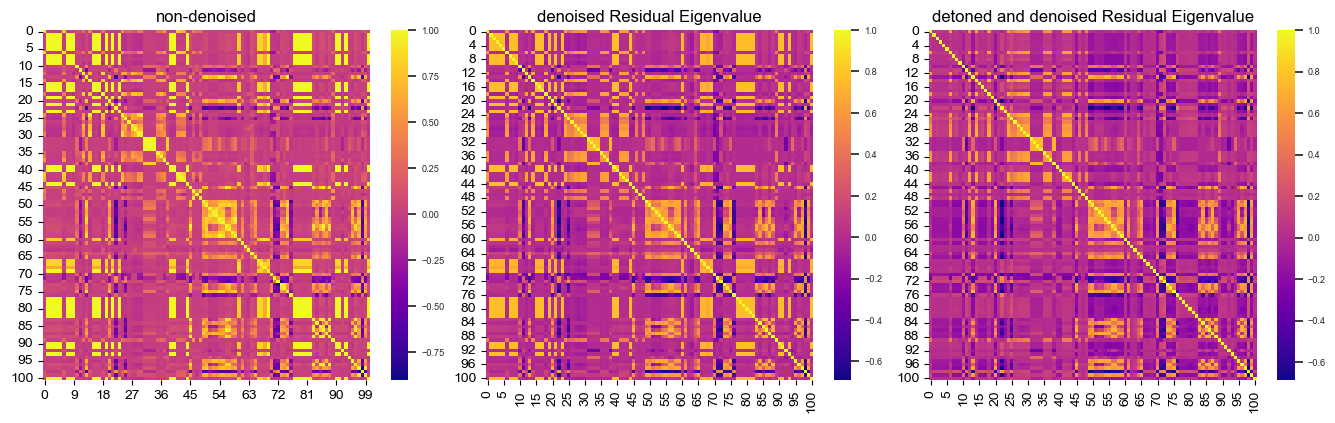

In [17]:
# Retrieves non-denoised Covariance and Correlation Matrices
cov0 = denoised_obj.get_cov_original
corr0 = denoised_obj.get_corr_original
corr1 = denoised_obj.get_corr_denoised
corr2=denoised_and_detoned_obj.get_corr_denoised
# Compare the correlation matrix before and after denoising
plotHeatMaps(corr0, corr1,corr2, 'Residual Eigenvalue')

In [18]:
# Save matrices to other modules (e.g. Principal Components)

#pd.DataFrame(corr0).to_csv('OrigCorrMatrix.csv')
#pd.DataFrame(corr1).to_csv('DenoisedCorrMatrix.csv')
#pd.DataFrame(denoised_obj.get_cov_original).to_csv('OrigCovMatrix.csv')
#pd.DataFrame(denoised_obj.get_cov_denoised).to_csv('DenoisedCovMatrix.csv')

The correlation matrices, we can see the granular aspect of the correlation of some variables in the denoised matrix (left) that was corrected by the $\textit{denoising process}$ in the denoised matrix (right).

# Calculate Marchenko-Pastur Density

The objective of the fit is to find the value of $\sigma^2$ and $q$ that minimizes the sum of the squared differences between the analytical PDF and the kernel density estimate (KDE) of the observed eigenvalues.

In [19]:
# Instanciate Marcenko Pastur processor
marcpastur_processor = Denoising(q=denoised_q)

In [20]:
def plotMPDensity(corr, denoising_transf):
    # Getting eigenvalues and eigenvectors
    eVal, eVec = denoising_transf.calc_PCA(corr)

    # Marchenko-Pastur pdf
    pdf0 = denoising_transf.calc_PDF(denoised_var)
    #pdf0 = denoising_transf.calc_PDF(denoised_var, X.shape[0]/float(X.shape[1])) # To see the unoptimized q

    # Empirical pdf
    pdf1= denoising_transf.fit_KDE(np.diag(eVal))

    # Plotting results
    ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue")
    pdf1.plot(label="Empirical Value", color="mediumspringgreen")
    ax.set(xlabel="λ", ylabel="prob[λ]")
    ax.set_yscale('log')
    ax.legend(loc="upper right")

    # Set the limits of the x and y axes
    ax.set_xlim([-0.1, 1.5])
    ax.set_ylim([0.1, 20])

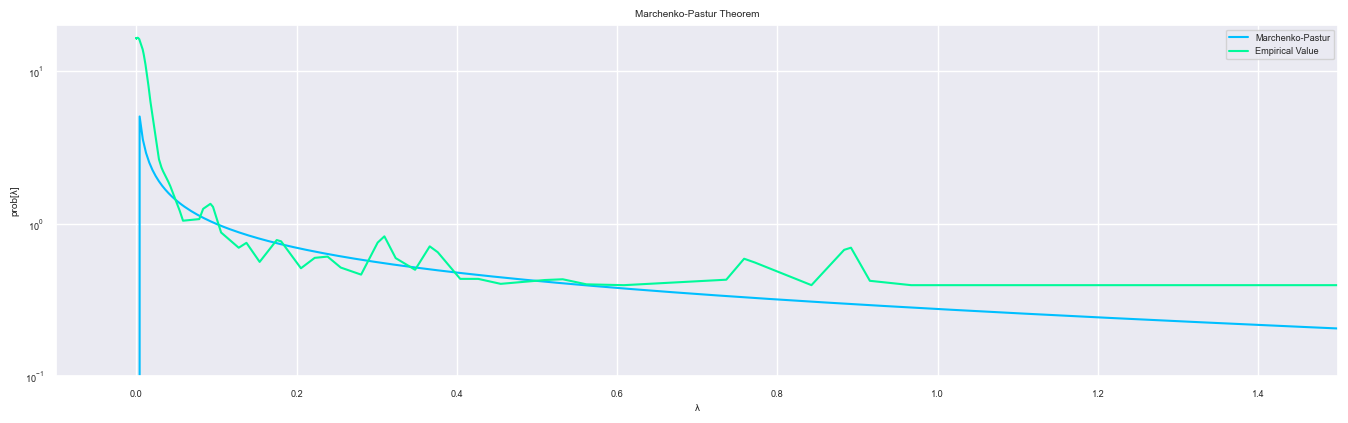

In [21]:
plotMPDensity(corr0, marcpastur_processor)

## Eigen Values compared with Marcenko Pastur distribution

In [22]:
def plotMPDistribution(corr, denoising_transf, nbins, y_scale = 'log'):
    # Getting Eigenvalues and Eigenvectors
    eVal, eVec = denoising_transf.calc_PCA(corr)

    # Getting Max Eigenvalues, calculating variance attributed to noise and independent q
    eMax, var, q = denoising_transf.find_max_eval(np.diag(eVal))
    #eMax, var, q = denoising_transf.find_max_eval(np.diag(eVal), X.shape[0]/float(X.shape[1])) # To see the unoptimized q
    nFacts0 = eVal.shape[0] - np.diag(eVal)[::-1].searchsorted(eMax)

    # Getting PDFs and plotting it
    pdf0 = denoising_transf.calc_PDF(var, q)

    # Plotting PDFs
    ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue", figsize=(10,7))
    ax.hist(pd.Series(np.diag(eVal)), density="norm", bins=nbins, label="Empirical Value", color="orange")
    ax.set(xlabel="λ", ylabel="prob[λ]")
    if (y_scale=='log'):
        ax.set_yscale('log')
    ax.legend(loc="upper right")
    print(f'(Eigenvalues:\n{np.diag(eVal)[:50]}')

Eigenvalues to the right of the fitted Marcenko–Pastur distribution cannot be associated with noise, thus they are
related to signal.

(Eigenvalues:
[30.63083483 19.25531667 10.50565229  6.98886137  4.51012302  3.27432585
  2.3791654   1.86131399  1.57594737  1.47134594  1.25245517  1.16483788
  1.02823014  0.96682471  0.9153076   0.89172923  0.883243    0.84241872
  0.77180401  0.75836736  0.73612436  0.60839677  0.56159469  0.5320238
  0.5095696   0.45455641  0.42659072  0.40407274  0.3760413   0.36602731
  0.34777112  0.32355197  0.30945362  0.30106131  0.28038574  0.25498197
  0.23855207  0.22248698  0.20531704  0.18058582  0.17511722  0.15377611
  0.13730053  0.12765745  0.10568236  0.09555941  0.09234665  0.08327526
  0.07847009  0.05813326]


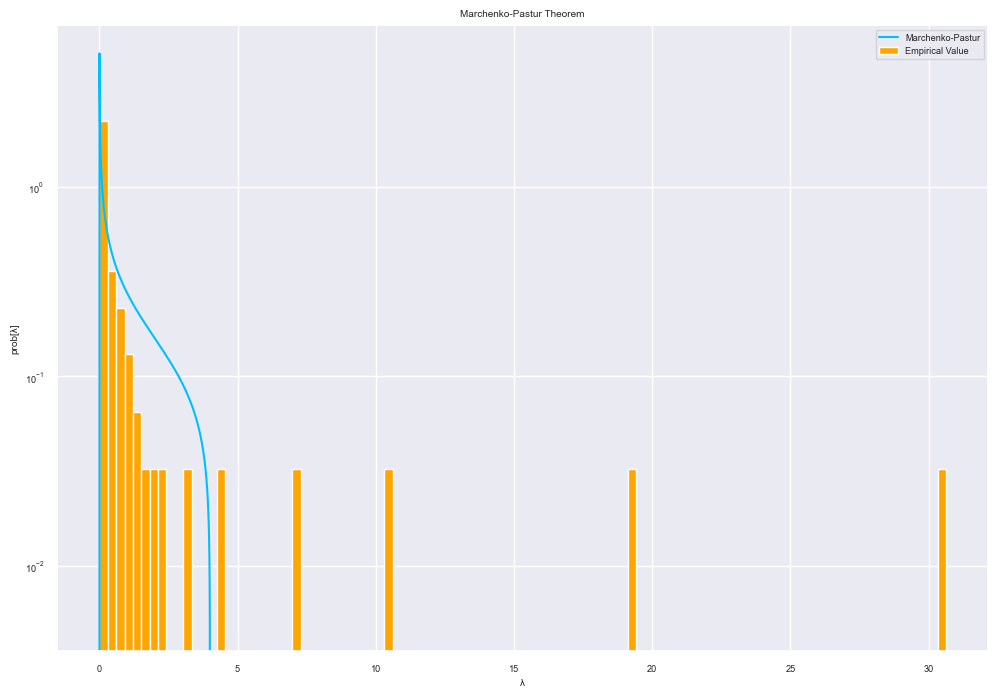

In [23]:
plotMPDistribution(corr0, marcpastur_processor, X.shape[1], y_scale = 'log')

## Using Marcenko Pastur with Syhthetic Data

This example was reproduced from $\textbf{Chap. 2}$ of  $\textit{Machine Learning for Asset Managers}$, by Marcos M. Lopez de Prado - 1st. edition.

Here the author creates a correlation matrix, not all eigenvectors may be random by building a covariance matrix that is not perfectly random, and hence its eigenvalues will only $\textit{approximately}$ follow the Marcenko–Pastur PDF.

In [24]:
# Adapted from SNIPPET 2.3 ADD SIGNAL TO A RANDOM COVARIANCE MATRIX (Lopez)
def get_random_cov(nCols,nFacts):
    w=np.random.normal(size=(nCols,nFacts))
    cov=np.dot(w,w.T) # random cov matrix, however not full rank
    cov+=np.diag(np.random.uniform(size=nCols)) # full rank cov
    return cov
#---------------------------------------------------
alpha,nCols,nFact,q=.99,1000,100,10.0
mp_f_processor = Denoising(alpha=alpha, q = q) 
cov=np.cov(np.random.normal(size=(10000,1000)),rowvar=0)
cov=alpha*cov+(1-alpha)*get_random_cov(nCols,nFact) # noise+signal
corr0_f=Denoising.cov_to_corr(cov)
eVal0_f,eVec0_f=mp_f_processor.calc_PCA(corr0_f)

(Eigenvalues:
[8.88793714 8.75968339 8.56112992 8.49203258 8.28376898 8.15919062
 8.04153022 7.9938755  7.92852902 7.79780673 7.72298719 7.65489705
 7.63417666 7.54070524 7.44761904 7.42813282 7.31173248 7.13768018
 7.13062361 7.04787278 6.97912321 6.89767372 6.82222194 6.79615631
 6.74154289 6.7011883  6.65628884 6.54072647 6.49727518 6.41137159
 6.35278509 6.30198291 6.27436585 6.19577466 6.15275919 6.13224759
 6.02921776 5.99790013 5.91896351 5.89633861 5.78370585 5.76719874
 5.68003559 5.64726086 5.59891118 5.55007946 5.49901348 5.42191577
 5.39918829 5.29213211]


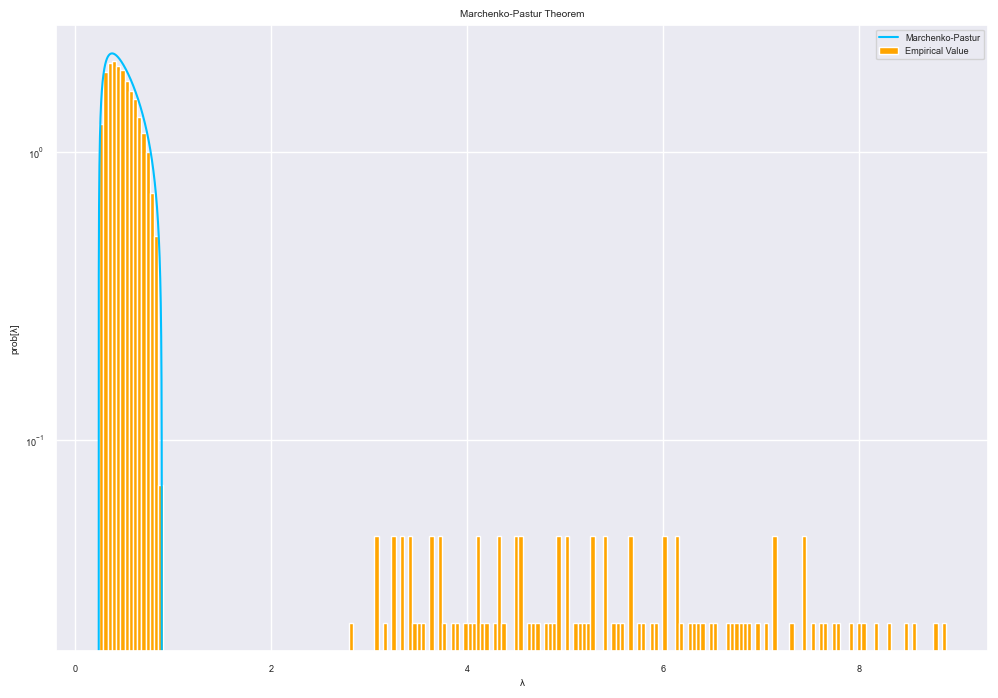

In [25]:
# Plot the distribution with Synthetic Data
plotMPDistribution(corr0_f, mp_f_processor, 200)

# Monte Carlo Simulation

Adapted from Chap. 2 of $\textit{Machine Learning for Asset Managers}$, by Marcos M. Lopez de Prado - 1st. edition


This block of code reproduces the example to compute the errors with estimating a minimum variance portfolio with and without noising.

## Generating Block Diagonal Matrix

I this block we generate a vector of means and a covariance matrix out of ten blocks of size fifty each, where offdiagonal
elements within each block have a correlation of 0.5. This covariance matrix is a stylized representation of a true (nonempirical) detoned correlation matrix of the $\textbf{S&P 500}$, where each block is associated with an economic sector. 

Variances are drawn from uniform distribution bounded $[.05, .2]$ and the means sampled from a Standard Normal distribution. This is consistent with the notion that in an efficient market all securities have the same expected Sharpe ratio.

In [26]:
from scipy.linalg import block_diag

# SNIPPET 2.7 GENERATING A BLOCK-DIAGONAL COVARIANCE MATRIX AND A VECTOR OF MEANS (Lopez)
def form_block_matrix(nBlocks,bSize,bCorr): 
    block=np.ones((bSize,bSize))*bCorr 
    block[range(bSize),range(bSize)]=1 
    corr=block_diag(*([block]*nBlocks)) 
    return corr
#--------------------------------------------------- 
def form_true_matrix(nBlocks,bSize,bCorr):
    corr0=form_block_matrix(nBlocks,bSize,bCorr) 
    corr0=pd.DataFrame(corr0)
    cols=corr0.columns.tolist()
    np.random.shuffle(cols) 
    corr0=corr0[cols].loc[cols].copy(deep=True) 
    std0=np.random.uniform(.05,.2,corr0.shape[0]) 
    cov0=Denoising.corr_to_cov(corr0,std0) 
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1) 
    return mu0,cov0

## Generating Empirical Covariance Matrix

Now, $\textbf{Lopez}$ uses the true (nonempirical) covariance matrix to draw a random matrix $\tilde{X}$ of size $T\times N$, and it derives the associated empirical covariance matrix and vector of means.

In [27]:
from sklearn.covariance import LedoitWolf

# SNIPPET 2.8 GENERATING THE EMPIRICAL COVARIANCE MATRIX
def sim_cov_mu(mu0, cov0, nObs, shrink=False): 
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs) 
    mu1=x.mean(axis=0).reshape(-1,1)
    if shrink:
        cov1=LedoitWolf().fit(x).covariance_ 
    else:
        cov1=np.cov(x,rowvar=0)
    return mu1,cov1

### Denoising the Empirical Cov Matrix

Here, Lopez applies the denoising routine to denoise the empirical covariance matrix. In this particular experiment, we denoise through the $\textit{constant residual eigenvalue}$ method.

In [28]:
# SNIPPET 2.9 DENOISING OF THE EMPIRICAL COVARIANCE MATRIX
#--------------------------------------------------- 
def denoise_cov(cov0,d_transf):
    corr0=Denoising.cov_to_corr(cov0)
    eVal0,eVec0=d_transf.calc_PCA(corr0) 
    eMax0,var0, q0=d_transf.find_max_eval(np.diag(eVal0)) 
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0) 
    corr1=d_transf.denoised_corr(eVal0,eVec0,nFacts0) 
    cov1=Denoising.corr_to_cov(corr1,np.diag(cov0)**.5)
    return cov1

In [29]:
#----- Generating Block Diagonal Cov Matrix and Vector of Means
nBlocks,bSize,bCorr=10,50,.5
np.random.seed(0)
mu0,cov0=form_true_matrix(nBlocks,bSize,bCorr)

In [30]:
#----- Generating Empirical Cov Matrix
mu1, cov1 = sim_cov_mu(mu0,cov0,1000,shrink=True)

In [31]:
#----- Comparison between Non-Denoised and Denoised Cov Matrices
def plotHeatMaps2 (corr0, corr1, txt: str):
    plt.rcParams["figure.figsize"] = [9.50, 4.25]
    plt.rcParams["figure.autolayout"] = True

    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.subplots_adjust(wspace=1)

    sns.set(font_scale=0.6)

    sns.heatmap(corr0, cmap="plasma", ax=ax1, cbar=True)
    sns.heatmap(corr1, cmap="plasma", ax=ax2, cbar=True)

    # ax2.yaxis.tick_right()

    ax1.set_title('non-denoised', fontsize=12)
    ax2.set_title('denoised '+txt, fontsize=12)


    fig.subplots_adjust(wspace=0.001)
    plt.show()


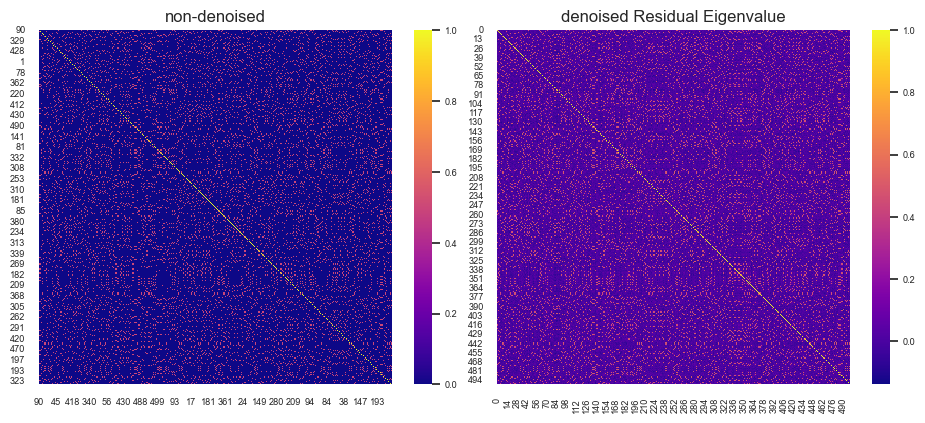

In [32]:
# Compare the correlation matrix before and after denoising
plotHeatMaps2(Denoising.cov_to_corr(cov0), Denoising.cov_to_corr(cov1), 'Residual Eigenvalue')

### Simulation

This runs the following $\textit{Monte Carlo experiment}$ with $1,000$ iterations: (1) draw a random empirical covariance matrix (shrinkage optional) with $T=1,000$; (2) denoise the empirical covariance matrix (optional); (3) derive the minimum variance portfolio, using the function $\texttt{optPort}$. When we pass the argument shrink=True to function $\texttt{simCovMu}$, the covariance matrix is shrunk.

In [33]:
def opt_port(cov,mu=None):
    inv = np.linalg.inv(cov)
    ones = np.ones(shape=(inv.shape[0],1))
    if mu is None:
        mu = ones
    w = np.dot(inv,mu)
    w /= np.dot(ones.T,w)
    return w
#---------------------------------------------------
nObs,nTrials,bWidth,shrink,minVarPortf=1000,100,.01,False,True

mc_processor = Denoising(q=nObs*1./cov1.shape[1])

w1=pd.DataFrame(columns=range(cov0.shape[0]),
        index=range(nTrials),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(0)
for i in range(nTrials):
    mu1,cov1=sim_cov_mu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf: 
        mu1=None
    cov1_d=denoise_cov(cov1,mc_processor)
    w1.loc[i]=opt_port(cov1,mu1).flatten()
    w1_d.loc[i]=opt_port(cov1_d,mu1).flatten()

Following the simulation, Lopez computes the true minimum variance portfolio, derived from the true covariance matrix. Using those allocations as benchmark, it then computes the root-mean-square errors (RMSE) across all weights, with and
without denoising.

In [34]:
#----- Root Mean Errors
w0=opt_port(cov0,None if minVarPortf else mu0)
w0=np.repeat(w0.T,w1.shape[0],axis=0)
rmsd=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE
rmsd_d=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE
print(f"Total RSME:")
print("-----------\n")
print(f"Non-Denoised {rmsd*100:.4f}% | Denoised {rmsd_d*100:.4f}%")
print(f"Ratio: {rmsd_d/rmsd:.4f}")

Total RSME:
-----------

Non-Denoised 0.4973% | Denoised 0.1136%
Ratio: 0.2285
